<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [58]:
# Set your student number
student_number = 400101175
Name = 'Mohammad Armin'
Last_Name = 'Dehghan'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [59]:
%pip install numpy
%pip install matplotlib
%pip install torchvision
%pip install torch

## Importing Libraries

In [60]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [61]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [62]:
## FILL HERE
num_classes = len(train_set.classes)
input_dim = train_set[0][0].numel() 

print(f"Number of classes: {num_classes}")
print(f"Input dimension of the first layer: {input_dim} pixels")

Number of classes: 10
Input dimension of the first layer: 784 pixels


In [63]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

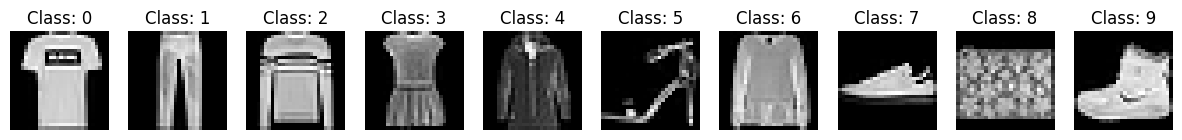

In [64]:
def visualize_random_images_from_each_class(dataset, num_classes):
    class_indices = {i: [] for i in range(num_classes)}
    
    # Collect indices for each class
    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < 1:
            class_indices[label].append(idx)
        if all(len(class_indices[c]) > 0 for c in range(num_classes)):
            break
    
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 15))
    for class_label, indices in class_indices.items():
        idx = indices[0]
        image, label = dataset[idx]
        axs[class_label].imshow(image.squeeze(), cmap='gray')
        axs[class_label].set_title(f'Class: {class_label}')
        axs[class_label].axis('off')
    
    plt.show()

visualize_random_images_from_each_class(train_set, num_classes)

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [65]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [66]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [67]:
def affine_forward(x, w, b):
    return x @ w + b    

def relu(x):
    return torch.maximum(x, torch.tensor(0.0, device=x.device))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [68]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        x = affine_forward(x, w, b)
        if i < num_layers - 1:
            x = relu(x)
    
    output = x
    return output


Implementing cross entropy loss:

In [69]:
def cross_entropy_loss(scores, y):
    n = len(y)
    exp_scores = torch.exp(scores)
    probs = exp_scores / exp_scores.sum(dim=1, keepdim=True)
    log_probs = torch.log(probs)
    correct_log_probs = log_probs[range(n), y]
    loss = -correct_log_probs.mean()
    
    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [70]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    with torch.no_grad():
        for param_name, param_tensor in parameters.items():
            if param_tensor.grad is not None:
                # Update the parameter using SGD
                param_tensor.data -= learning_rate * param_tensor.grad
                
                # Zero out the gradient
                param_tensor.grad.zero_()

Training functions:

In [71]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    correct_predictions = np.sum(y_pred == y_true)
    acc = correct_predictions / len(y_true)
    
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        loss = cross_entropy_loss(p, y)
        for param in parameters.values():
            if param.grad is not None:
                param.grad.zero_()
        
        loss.backward()
        sgd_optimizer(parameters, learning_rate)
        train_loss += loss.item()

        print(f'Epoch {epoch}, Batch {i + 1}, Loss: {loss.item()}')

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    train_loss /= len(Y_pred)
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        # Calculate the loss
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()  
        print(f'Epoch {epoch}, Batch {i + 1}, {set_name} Loss: {loss.item()}')
            
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= len(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [72]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [73]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    
    for epoch in range(num_epochs):
        # Training Phase
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation Phase
        test_loss, test_acc = validate(test_loader, epoch, set_name="Test")
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    # Plot the loss history of training and test sets
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    # Plot the accuracy history of training and test sets
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 0, Batch 1, Loss: 2.3022491931915283
Epoch 0, Batch 2, Loss: 2.3049302101135254
Epoch 0, Batch 3, Loss: 2.304715633392334
Epoch 0, Batch 4, Loss: 2.3050694465637207
Epoch 0, Batch 5, Loss: 2.3047244548797607
Epoch 0, Batch 6, Loss: 2.303736686706543
Epoch 0, Batch 7, Loss: 2.306452751159668
Epoch 0, Batch 8, Loss: 2.3034558296203613
Epoch 0, Batch 9, Loss: 2.305197238922119
Epoch 0, Batch 10, Loss: 2.3028035163879395
Epoch 0, Batch 11, Loss: 2.30434513092041
Epoch 0, Batch 12, Loss: 2.3028512001037598
Epoch 0, Batch 13, Loss: 2.302873134613037
Epoch 0, Batch 14, Loss: 2.303029775619507
Epoch 0, Batch 15, Loss: 2.3034398555755615
Epoch 0, Batch 16, Loss: 2.3045620918273926
Epoch 0, Batch 17, Loss: 2.3038344383239746
Epoch 0, Batch 18, Loss: 2.3045289516448975
Epoch 0, Batch 19, Loss: 2.304533004760742
Epoch 0, Batch 20, Loss: 2.3039073944091797
Epoch 0, Batch 21, Loss: 2.303823709487915
Epoch 0, Batch 22, Loss: 2.305833578109741
Epoch 0, Batch 23, Loss: 2.302274227142334
Epoch 0, 

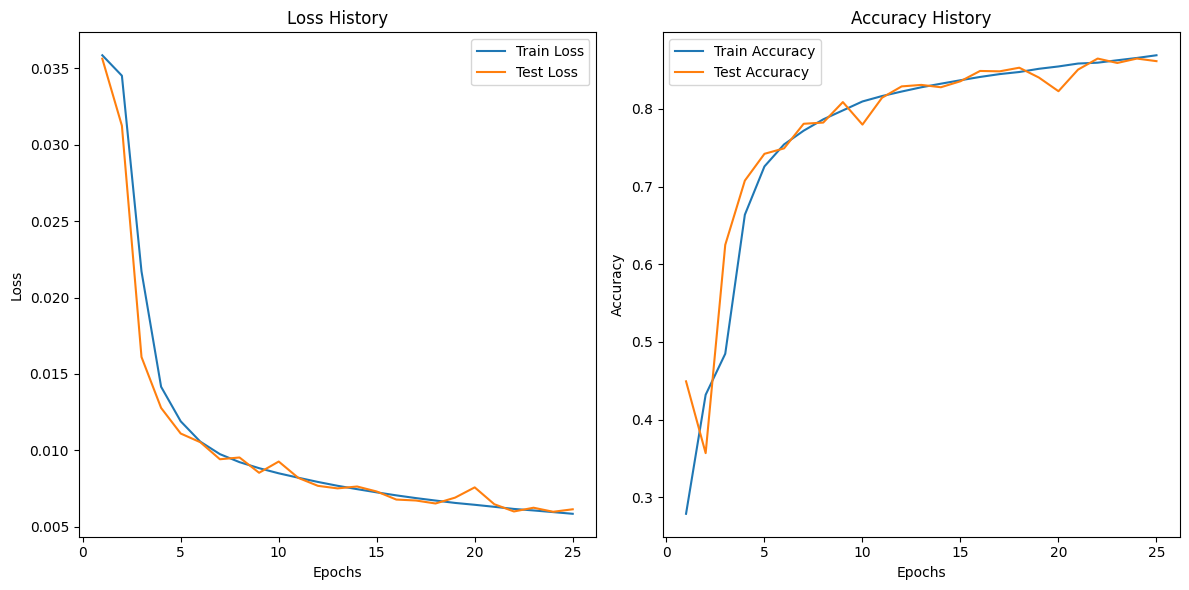

In [74]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [75]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8615


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

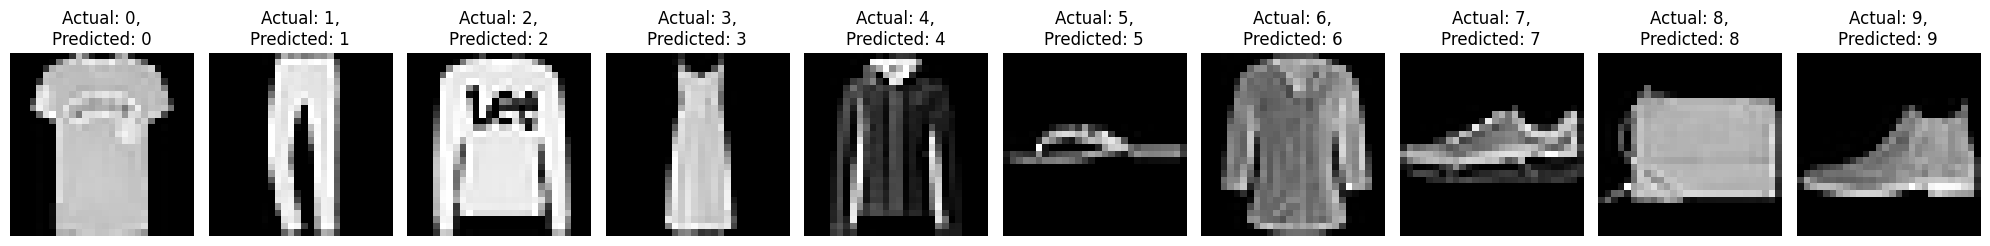

In [76]:
# Define predict function
def predict(x):
    output = model(x, parameters)
    predicted_classes = torch.argmax(output, dim=1)
    return predicted_classes

# Visualize one image from each class with actual and predicted labels
def visualize_predictions(parameters, test_loader, num_classes):
    class_indices = {i: [] for i in range(num_classes)}

    # Collect indices for each class
    for idx, (image, label) in enumerate(test_loader.dataset):
        if len(class_indices[label]) < 1:
            class_indices[label].append(idx)
        if all(len(class_indices[c]) > 0 for c in range(num_classes)):
            break

    fig, axs = plt.subplots(1, num_classes, figsize=(20, 20))

    for class_label, indices in class_indices.items():
        idx = indices[0]
        image, label = test_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        predicted_label = predict(image).item()

        axs[class_label].imshow(image.cpu().squeeze(), cmap='gray')
        axs[class_label].set_title(f'Actual: {label},\nPredicted: {predicted_label}', fontsize=12)
        axs[class_label].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(parameters, test_loader, num_classes)
